# Модель оценки кредитного риска на основе данных о выданных розничных кредитах.

## Загрузка программных модулей и данных

In [1]:
# Импортируем необходимые библиотеки для обработки и визуализации данных.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# импортируем средства для отбора и предобработки признаков, разделения данных, настройки параметров моделей,
# сами модели, средства оценки результатов

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score

In [3]:
# читаем данные
data = pd.read_csv('c:/Users/User/Desktop/skoring-train.csv')

## Предварительный осмотр данных

In [4]:
# видим, что пропуски есть только в признаке education
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   client_id         73799 non-null  int64 
 1   education         73492 non-null  object
 2   sex               73799 non-null  object
 3   age               73799 non-null  int64 
 4   car               73799 non-null  object
 5   car_type          73799 non-null  object
 6   decline_app_cnt   73799 non-null  int64 
 7   good_work         73799 non-null  int64 
 8   bki_request_cnt   73799 non-null  int64 
 9   home_address      73799 non-null  int64 
 10  work_address      73799 non-null  int64 
 11  income            73799 non-null  int64 
 12  foreign_passport  73799 non-null  object
 13  default           73799 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 7.9+ MB


In [5]:
# несколько строк датафрейма
data.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,SCH,M,62,Y,Y,0,0,1,1,2,18000,N,0
1,63161,SCH,F,59,N,N,0,0,3,2,3,19000,N,0
2,25887,SCH,M,25,Y,N,2,0,1,1,2,30000,Y,0
3,16222,SCH,F,53,N,N,0,0,2,2,3,10000,N,0
4,101655,GRD,M,48,N,N,0,1,1,2,3,30000,Y,0


__Итак, наши данные:__

 - __client_id__	идентификатор клиента
 - __education__	уровень образования
 - __sex__	пол заёмщика
 - __age__	возраст заёмщика
 - __car__	флаг наличия автомобиля
 - __car_type__	флаг автомобиля-иномарки
 - __decline_app_cnt__	количество отказанных прошлых заявок
 - __good_work__	флаг наличия «хорошей» работы
 - __bki_request_cnt__	количество запросов в БКИ
 - __home_address__	категоризатор домашнего адреса
 - __work_address__	категоризатор рабочего адреса
 - __income	доход__ заёмщика
 - __foreign_passport__	наличие загранпаспорта
 - __default__	наличие дефолта

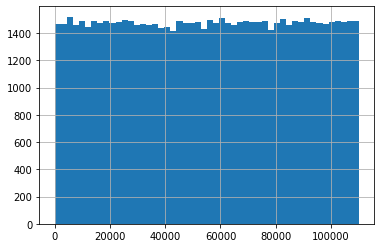

In [6]:
# идентификаторы клиентов распределены в промежутке от 1 до 110147 приблизительно равномерно. Очень жаль, что 
# даты событий, характеризующих взаимоотношения с клиентами ( обращение, выдача кредита, возврат, выплаты по 
# кредиту, дефолт)
data.client_id.hist(bins=50);

In [7]:
data.client_id.describe()

count     73799.000000
mean      55137.965094
std       31841.921168
min           1.000000
25%       27440.500000
50%       55274.000000
75%       82758.500000
max      110147.000000
Name: client_id, dtype: float64

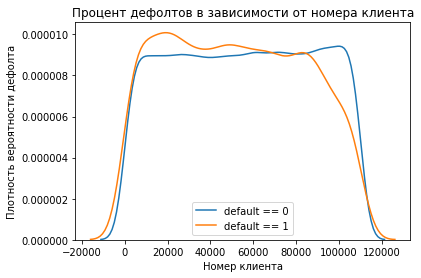

In [8]:
sns.kdeplot(data.loc[data.default == 0, 'client_id'] , label = 'default == 0')
sns.kdeplot(data.loc[data.default == 1, 'client_id'] , label = 'default == 1')
plt.xlabel('Номер клиента'); plt.ylabel('Плотность вероятности дефолта'); 
plt.title('Процент дефолтов в зависимости от номера клиента');

Видно, на первых группах клиентов (client_id от 0 до 65000) процент дефолтов был явно выше, потом ( с 65000 до 85000 ) он выровнялся, а после примерно 85000-го клиента - начал резко падать. Может, в этот момент банк начал классифицировать клиентов на компьютере?

## Первоначальный анализ. Корреляции.

In [9]:
# корреляция между признаками и корреляция признаков с целевой переменной невысока, кроме признаков 
# home_address и work_address . Интересно, что признаки home_address и work_address неплохо коррелируют 
# с  признаком client_id.
data.corr()

,client_id,age,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,default
client_id,1.000000,0.015435,-0.021417,0.004749,-0.029028,0.165555,0.165777,-0.000099,-0.039242
age,0.015435,1.000000,-0.111175,-0.076158,0.046265,0.010392,-0.006299,-0.018900,-0.025004
decline_app_cnt,-0.021417,-0.111175,1.000000,-0.027359,0.155894,0.012530,0.016234,-0.021687,0.113682
good_work,0.004749,-0.076158,-0.027359,1.000000,0.005738,-0.003624,-0.008535,0.022705,-0.043361
bki_request_cnt,-0.029028,0.046265,0.155894,0.005738,1.000000,0.008183,0.005553,0.082983,0.078242
home_address,0.165555,0.010392,0.012530,-0.003624,0.008183,1.000000,0.728139,0.038343,0.084637
work_address,0.165777,-0.006299,0.016234,-0.008535,0.005553,0.728139,1.000000,0.049721,0.081582
income,-0.000099,-0.018900,-0.021687,0.022705,0.082983,0.038343,0.049721,1.000000,-0.039752
default,-0.039242,-0.025004,0.113682,-0.043361,0.078242,0.084637,0.081582,-0.039752,1.000000


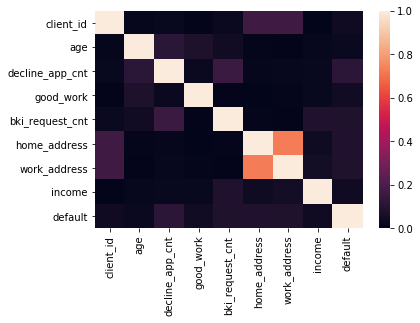

In [10]:
sns.heatmap(data.corr().abs(), vmin=0, vmax=1);

В среднем признаки несильно влияют на вероятность дефолта. Но влияние различных значений признаков на нее более выражено. Поэтому мы можем сконструировать новые признаки, в которых это влияние отражено напрямую. Будем надеяться, что они лучше подскажут модели, как классифицировать клиентов, обратившихся за кредитом.

In [11]:
# найдем среднюю вероятность дефолта на нашей выборке клиентов.
def_mean = data.default.mean()

In [12]:
# она равна 12.7%. Это весьма высокая цифра.
def_mean

0.12699359069906097

Изучим последовательно все признаки и посмотрим, что можно сделать на их основе.

## Образование клиента

In [13]:
data.education.value_counts(dropna=False)

SCH    38860
GRD    23365
UGR     9816
PGR     1257
NaN      307
ACD      194
Name: education, dtype: int64

Наиболее часто встречаются клиенты со средним образованием, на втором месте - с высшим.

In [14]:
# Так как мы имеем всего менее 0.5 процента пропусков, заполним их модой
data.education.fillna('SCH', inplace=True)

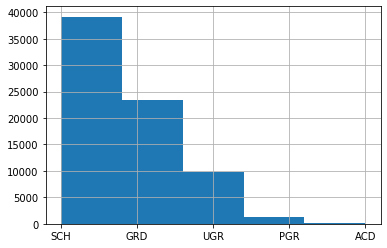

In [15]:
data.education.hist(bins=5);

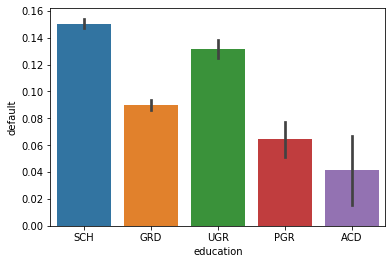

In [16]:
# видим, что высокообразованные люди реже допускают дефолт по кредиту. 
# Попробуем на основе этой закономерности сделать новый признак, более удобный для классификации.
sns.barplot(data=data, x='education', y='default');

In [17]:
# Для этого сгруппируем процент дефолта в зависимости от уровня образования, как на графике выше.
def_by_edu = data.groupby(by='education').agg({'default':'mean'})

In [18]:
# Вот что мы получили
def_by_edu

,default
education,
ACD,0.041237
GRD,0.090092
PGR,0.064439
SCH,0.150305
UGR,0.131520


In [19]:
# сделаем список всех уровней образования
edu_lst = data.education.unique()

In [20]:
# вот он
edu_lst

array(['SCH', 'GRD', 'UGR', 'PGR', 'ACD'], dtype=object)

In [21]:
# присвоим каждому клиенту признак, равный среднему числу дефолтов среди клиентов его образовательного уровня
data['def_by_edu'] = 0
for edu in edu_lst:
    mask = data.education==edu
    data.loc[mask,'def_by_edu'] = (def_by_edu['default'][edu] - def_mean)/def_mean

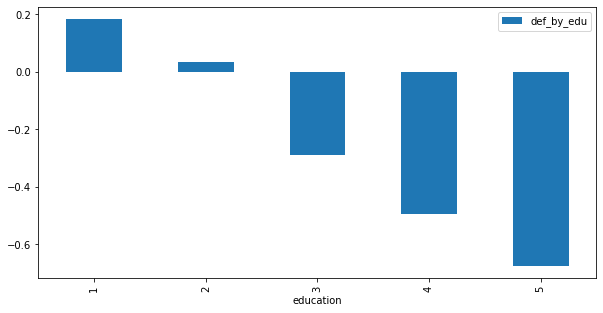

In [22]:
# наш новый признак изменяется в широком диапазоне:
data.education = data.education.map({'SCH':1, 'GRD':3, 'UGR':2, 'PGR':4, 'ACD':5})
data.groupby(by='education').agg({'def_by_edu':'mean'}).plot(kind='bar', figsize=(10,5));

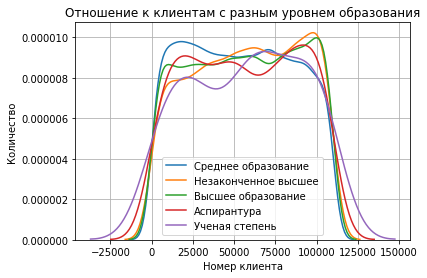

In [25]:
# Проверим, как менялось отношение банка к клиентам с разным уровнем образования: 
sns.kdeplot(data.loc[data.education == 1, 'client_id'] , label = 'Среднее образование')
sns.kdeplot(data.loc[data.education == 2, 'client_id'] , label = 'Незаконченное высшее')
sns.kdeplot(data.loc[data.education == 3, 'client_id'] , label = 'Высшее образование')
sns.kdeplot(data.loc[data.education == 4, 'client_id'] , label = 'Аспирантура')
sns.kdeplot(data.loc[data.education == 5, 'client_id'] , label = 'Ученая степень')
plt.xlabel('Номер клиента'); plt.ylabel('Количество'); 
plt.title('Отношение к клиентам с разным уровнем образования');plt.grid(axis='both');

Примерно с 80000 клиента банк начал кредитовать относительно больше лиц с незаконченным высшим, высшим образованием и слушателей/выпускников аспирантуры, сократив кредитование лиц со средним образованием и с ученой степенью.

## Пол клиента

In [24]:
# Выясняем, что признак принимает 2 значения ( фу, какая скука ) и пропусков нет.
data.sex.value_counts(normalize=True)

F    0.563178
M    0.436822
Name: sex, dtype: float64

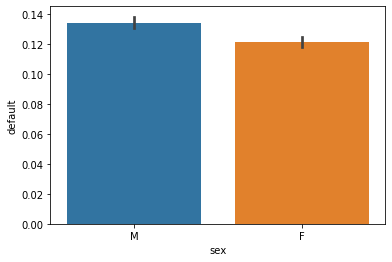

In [26]:
# Мужчины допускают дефолт чаще
sns.barplot(data=data, x='sex', y='default');

In [27]:
# Группируем
def_by_sex = data.groupby(by='sex').agg({'default':'mean'})

In [28]:
# видим на цифрах
def_by_sex

,default
sex,
F,0.121241
M,0.134411


In [29]:
# делаем список полов
sex_lst = data.sex.unique()

In [30]:
# Присваиваем каждому клиенту процент дефолта клиентов его пола
data['def_by_sex'] = 0
for sex in sex_lst:
    mask = data.sex==sex
    data.loc[mask,'def_by_sex'] = (def_by_sex['default'][sex] - def_mean)/def_mean

In [31]:
# Перекодируем в цифры
data.sex = data.sex.map({'F':1, 'M':0})

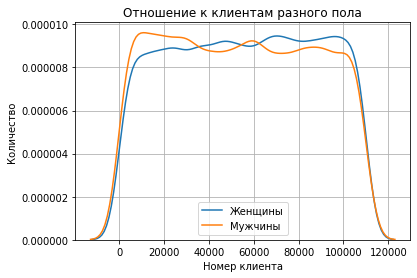

In [33]:
# Проверим, как менялось отношение банка к клиентам разного пола: 
sns.kdeplot(data.loc[data.sex == 1, 'client_id'] , label = 'Женщины')
sns.kdeplot(data.loc[data.sex == 0, 'client_id'] , label = 'Мужчины')
plt.xlabel('Номер клиента'); plt.ylabel('Количество'); 
plt.title('Отношение к клиентам разного пола');plt.grid(axis='both');

Видно, что после 60000 клиента банк немного больше полюбил заемщиков-женщин.

## Возраст

Возраст - числовой признак. Для числовых признаков нам потребуется исследование на выбросы. Определим функцию, которая будет искать выбросы в числовых признаках.

In [34]:
# Наш банк дает кредиты лицам в возрасте с 21 до 72 лет
data.age.describe()

count    73799.000000
mean        39.280641
std         11.520378
min         21.000000
25%         30.000000
50%         37.000000
75%         48.000000
max         72.000000
Name: age, dtype: float64

In [35]:
def outliers_iqr(ys):
    # находим квартили
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    # находим межквартильное расстояние
    iqr = quartile_3 - quartile_1
    # нижняя граница коробки
    lower_bound = quartile_1 - (iqr * 1.5)
    # верхняя граница коробки
    upper_bound = quartile_3 + (iqr * 1.5)
    # возращаем только те значения и их индексы, ктр больше upper_bound и меньше lower_bound
    return ys[((ys > upper_bound) | (ys < lower_bound))], lower_bound, upper_bound

In [36]:
out, lower_bound, upper_bound = outliers_iqr(data.age)

In [37]:
# с такими границами у нас выбросов по возрасту нет
lower_bound, upper_bound

(3.0, 75.0)

In [38]:
# И точно, нет
out

Series([], Name: age, dtype: int64)

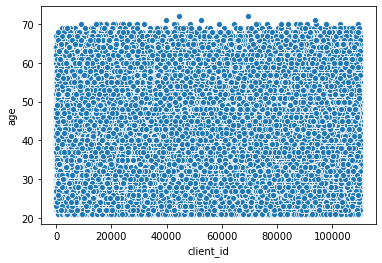

In [40]:
# Интересно, как менялась возрастная структура заемщиков (похоже, предпочтений по возрату не было):
sns.scatterplot(x='client_id', y='age', data=data);

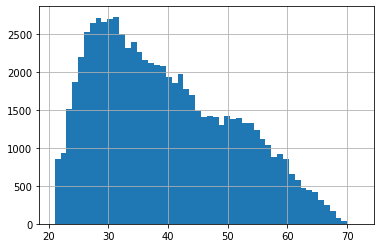

In [41]:
# Тем не менее распределение по возрасту имеет моду в 32 года и длинный толстый хвост 
data.age.hist(bins=52);

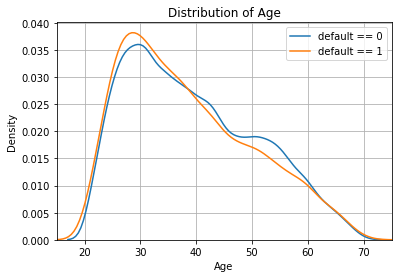

In [43]:
# Внимательно присмотримся к проценту дефолта в зависимости от возраста заемщика ( в среднем корреляции
#почти нет, как мы помним)
sns.kdeplot(data.loc[data.default == 0, 'age'] , label = 'default == 0')
sns.kdeplot(data.loc[data.default == 1, 'age'] , label = 'default == 1')
plt.xlabel('Age'); plt.ylabel('Density'); plt.title('Distribution of Age');plt.xlim(15, 75);
plt.grid(axis='both');

Видим, что заемщики моложе 37 лет в среднем хуже возвращают кредит, а с 37 до 63 - лучше. Видимо, имеет смысл сконструировать признак среднего процента дефолта по возрастам.

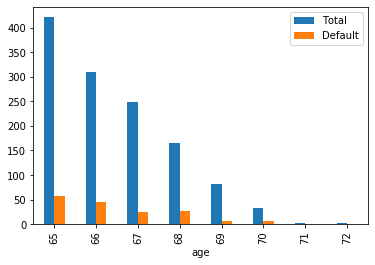

In [44]:
# максимальный возраст заемщика - 72 года, но таких мало, что плохо для вычисления статистических параметров
# Присмотримся внимательно к заемщикам - пенсионерам
s1 = (data.loc[data.default==1]).groupby(by='age').agg({'client_id':'count'})
s2 = data.groupby(by='age').agg({'client_id':'count'})
# s3 = s1.divide(s2)
Age = pd.concat([s2,s1], axis=1).fillna(0)
Age.columns = ['Total','Default']
Age[Age.index>=65].plot(kind='bar');

Видно, что, начиная с возраста 69 лет дефолтных заемщиков настолько мало, что статистика не работает, надо для этих возрастов не вычислять средний процент дефолта, а присваивать какое-то большое значение, например, 0.2

In [45]:
# Вычисляем список всех возрастов
age_lst = data.age.unique()

In [46]:
# Группируем процент дефолта в зависимости от возраста
def_by_age = data.groupby(by='age').agg({'default':'mean'})

In [47]:
data['def_by_age'] = 0
for age in age_lst:
    mask = data.age==age
    data.loc[mask,'def_by_age'] = (def_by_age['default'][age] - def_mean)/def_mean
    if age<=68:
        data.loc[mask,'def_by_age'] = (def_by_age['default'][age] - def_mean)/def_mean
    else:
        data.loc[mask,'def_by_age'] = (0.2 - def_mean)/def_mean

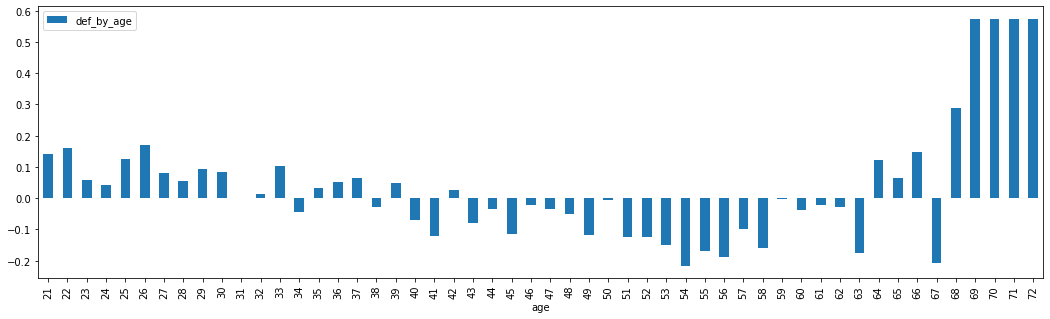

In [48]:
# мы классифицировали заемщиков по проценту дефолтов от возраста
data.groupby(by='age').agg({'def_by_age':'mean'}).plot(kind='bar', figsize=(18,5));

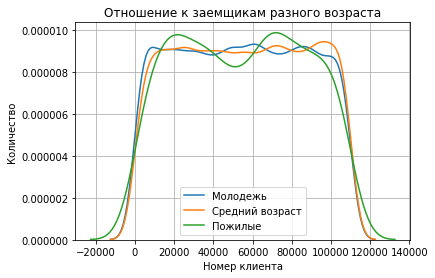

In [49]:
# Проверим, как менялось отношение банка к заемщикам разного возраста:
sns.kdeplot(data.loc[data.age <= 37, 'client_id'] , label = 'Молодежь')
sns.kdeplot(data.loc[(data.age > 37)&(data.age <= 63), 'client_id'] , label = 'Средний возраст')
sns.kdeplot(data.loc[data.age > 63, 'client_id'] , label = 'Пожилые')
plt.xlabel('Номер клиента'); plt.ylabel('Количество'); plt.title('Отношение к заемщикам разного возраста');
plt.grid(axis='both');

В целом отношение к заемщикам разного возраста ровное.

## Наличие автомобиля

Заемщики-автолюбители, а в особенности, владельцы иномарок, более аккуратны. Мы введем новый признак, классифицирующий их, на основе признаков 'car' и 'car_type'.

In [50]:
# Проверим, что в нашем татасете нет ошибок в этих признаках:
len(data[(data.car==0)&(data.car_type==1)])

0

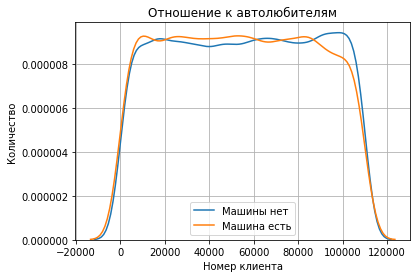

In [51]:
# Проверим, как менялось отношение банка к автомобилистам в зависимости от номера заемщика:
sns.kdeplot(data.loc[data.car == 'N', 'client_id'] , label = 'Машины нет')
sns.kdeplot(data.loc[data.car == 'Y', 'client_id'] , label = 'Машина есть')
plt.xlabel('Номер клиента'); plt.ylabel('Количество'); plt.title('Отношение к автолюбителям');
plt.grid(axis='both');

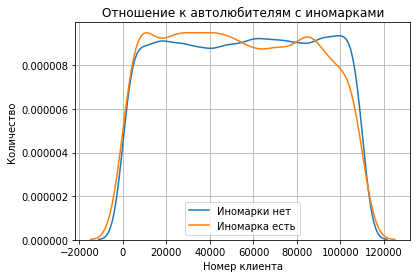

In [52]:
# Проверим, как менялось отношение банка к владельцам иномарок в зависимости от номера заемщика:
sns.kdeplot(data.loc[data.car_type == 'N', 'client_id'] , label = 'Иномарки нет')
sns.kdeplot(data.loc[data.car_type == 'Y', 'client_id'] , label = 'Иномарка есть')
plt.xlabel('Номер клиента'); plt.ylabel('Количество'); plt.title('Отношение к автолюбителям с иномарками');
plt.grid(axis='both');

__Вывод:__ похоже, наличие машины не стало признаком, на который стали обращать внимание, начиная с клиента номер 85000, когда количество дефолтов упало.

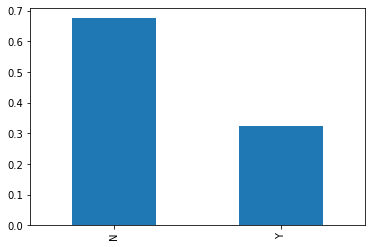

In [53]:
# 70% заемщиков не имеют машину
data.car.value_counts(normalize=True).plot(kind='bar');

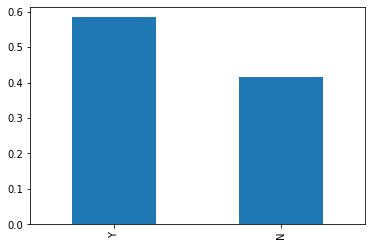

In [54]:
# Зато 60% заемщиков с машиной имеют иномарку
data[data.car=='Y'].car_type.value_counts(normalize=True).plot(kind='bar');

In [55]:
# Итак, первый список значений:
car_lst = data.car.unique()

In [56]:
# Второй список значений:
cartype_lst = data.car_type.unique()

In [57]:
# Группировка:
def_by_any_car = data.groupby(by=['car','car_type']).agg({'default':'mean'})

In [58]:
# Результат:
def_by_any_car

default
car car_type          
N   N         0.136960
Y   N         0.132744
    Y         0.087450

In [59]:
# Присвоение признака:
data['def_by_any_car'] = 0
for car in car_lst:
    for cartype in cartype_lst:
        if (car=='N') and (cartype=='Y'): continue
        mask = (data.car==car)&(data.car_type==cartype)
        data.loc[mask,'def_by_any_car'] = (def_by_any_car['default'][car,cartype] - def_mean)/def_mean

In [60]:
# Что мы получили: 
data['def_by_any_car'].value_counts()

 0.078481    49832
-0.311382    14008
 0.045283     9959
Name: def_by_any_car, dtype: int64

In [61]:
# Перекодируем в цифры
data.car = data.car.map({'Y':1, 'N':0})
data.car_type = data.car_type.map({'Y':1, 'N':0})

## Количество отказанных прошлых заявок

In [62]:
# видим, что все записи с отказами - за границей 75% квартиля. Это выбросы?
data.decline_app_cnt.describe()

count    73799.000000
mean         0.275749
std          0.804272
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         33.000000
Name: decline_app_cnt, dtype: float64

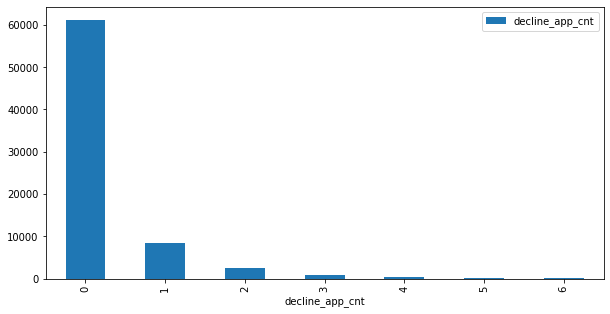

In [63]:
# Есть заемщики, которым отказывали по 33 раза, а потом выдали кредит, но значимые количества заемщиков
# изображены ниже в зависимости от коичества предыдущих отказов
data[data.decline_app_cnt <= 6].groupby(by='decline_app_cnt').agg(
    {'decline_app_cnt': 'count'}).plot(kind='bar', figsize=(10, 5));

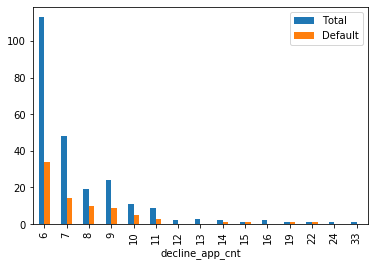

In [64]:
# Вот он наш хвост распределения ( вместе с дефолтами). Видно, что при количестве предыдущих 
# отказов >6 мы не в состоянии статистически достоверно судить о проценте дефолтов на основе имеющихся данных
#(число дефолтов в данных слишком мало)
s1 = (data.loc[data.default==1]).groupby(by='decline_app_cnt').agg({'client_id':'count'})
s2 = data.groupby(by='decline_app_cnt').agg({'client_id':'count'})

decline = pd.concat([s2,s1], axis=1).fillna(0)
decline.columns = ['Total','Default']
decline[decline.index>=6].plot(kind='bar');

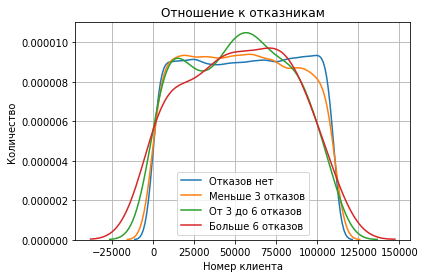

In [65]:
# Проверим, как менялось отношение банка к отказникам в зависимости от номера заемщика:
sns.kdeplot(data.loc[data.decline_app_cnt == 0,
                     'client_id'], label='Отказов нет')
sns.kdeplot(data.loc[(data.decline_app_cnt > 0) & (
    data.decline_app_cnt <= 2), 'client_id'], label='Меньше 3 отказов')
sns.kdeplot(data.loc[(data.decline_app_cnt > 3) & (
    data.decline_app_cnt <= 6), 'client_id'], label='От 3 до 6 отказов')
sns.kdeplot(data.loc[(data.decline_app_cnt > 6),
                     'client_id'], label='Больше 6 отказов')
plt.xlabel('Номер клиента')
plt.ylabel('Количество')
plt.title('Отношение к отказникам');
plt.grid(axis='both');

__Вывод:__ Отказников стали хуже кредитовать, начиная примерно с 75000-го клиента. Тех, кто имеет 3 и более отказов - значительно хуже.

Следует определить, какие данные являются выбросами по признаку количества предыдущих отказов. Применим соответствующую функцию:

In [66]:
out, lower_bound, upper_bound = outliers_iqr(data.decline_app_cnt)

Выясняется, что выбросы - это все данные о клиентах с отказами.

In [67]:
lower_bound, upper_bound

(0.0, 0.0)

In [68]:
# Если исключить все записи, признанные выбросами, то наш датасет значительно обеднеет.
len(out)

12585

In [69]:
# Нам нужны отказники для классификации, так как средний процент дефолтов по ним выше, 
# чем по клиентам без отказов
data.loc[data.decline_app_cnt > 0, 'default'].mean(),data.loc[data.decline_app_cnt == 0, 'default'].mean()

(0.21191895113230036, 0.1095337667853759)

Предлагаю по данным об отказах строить 2 признака: один из них - бинарный ( есть или нет отказы ), второй - числовой, основанный на проценте дефолтов заемщиков с разным числом отказов.

In [70]:
# Строим первый признак - 'has_decline', принимающий значение 0, если отказов не было, и 1, если они были
data['has_decline'] = (data.decline_app_cnt > 0).astype('uint8')

In [71]:
# Начинаем строить второй признак, основанный на числе отказов. Сначала список всех значений параметра
decappcnt_lst = data.decline_app_cnt.unique()

In [72]:
decappcnt_lst

array([ 0,  2,  1,  3,  4,  6,  5,  7,  8,  9, 13, 11, 19, 10, 22, 33, 14,
       12, 15, 24, 16], dtype=int64)

In [73]:
def_by_decappcnt = data.groupby(by='decline_app_cnt').agg({'default':'mean'})

In [74]:
# В наших данных статистически значимое количество дефолтов есть для клиентов с числом отказов <=6
data['def_by_decappcnt'] = 0
for decappcnt in decappcnt_lst:    
    mask = (data.decline_app_cnt==decappcnt)
    if decappcnt<=6:
        data.loc[mask,'def_by_decappcnt'] = (def_by_decappcnt['default'][decappcnt] - def_mean)/def_mean
    else:
        data.loc[mask,'def_by_decappcnt'] = (0.3 - def_mean)/def_mean
   

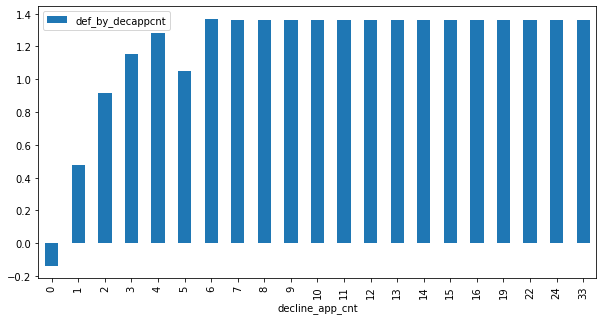

In [75]:
# мы классифицировали заемщиков по проценту дефолтов в зависимости от числа предыдущих отказов в кредите
data.groupby(by='decline_app_cnt').agg({'def_by_decappcnt':'mean'}).plot(kind='bar', figsize=(10,5));

## Признак на основе работы заемщика.

In [76]:
# Если заемщик работает дата сайентистом, то он надежнее, чем сезонный рабочий на сборе кедровых шишек.
# Но хорошая работа есть лишь у 16% заемщиков
data.good_work.value_counts(normalize=True)

0    0.835106
1    0.164894
Name: good_work, dtype: float64

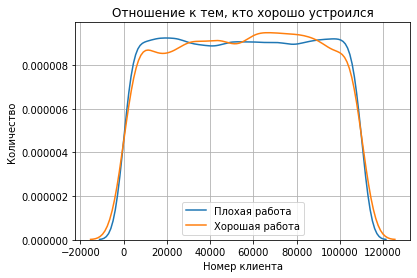

In [77]:
# Выясним, как менялось отношение банка к работе заемщика в зависимости от его номера
sns.kdeplot(data.loc[data.good_work == 0, 'client_id'] , label = 'Плохая работа')
sns.kdeplot(data.loc[data.good_work > 0, 'client_id'] , label = 'Хорошая работа')
plt.xlabel('Номер клиента'); plt.ylabel('Количество'); plt.title('Отношение к тем, кто хорошо устроился');
plt.grid(axis='both');

Огорчительно, но, явных предпочтений не было вначале, и они не появились потом.

In [78]:
# Строим список значений признака
goodw_lst = data.good_work.unique()

In [79]:
# Группируем проценты дефолта
def_by_goodw = data.groupby(by='good_work').agg({'default':'mean'})

In [80]:
# Получаем
def_by_goodw

,default
good_work,
0,0.133409
1,0.094502


In [81]:
# Присваиваем значения новому признаку
data['def_by_goodw'] = 0
for goodw in goodw_lst:
    mask = data.good_work==goodw
    data.loc[mask,'def_by_goodw'] = (def_by_goodw['default'][goodw] - def_mean)/def_mean

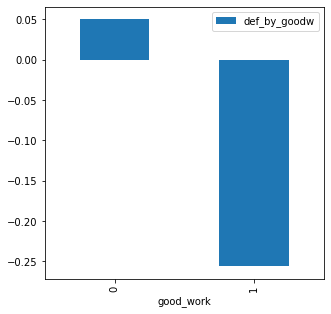

In [82]:
# Смотрим, что получилось
data.groupby(by='good_work').agg({'def_by_goodw':'mean'}).plot(kind='bar', figsize=(5,5));

## Количество запросов в БКИ

In [83]:
# видим, что все записи с числом запросов больше 3 - за границей 75% квартиля. 
# В каком диапазоне находятся выбросы?
data.bki_request_cnt.describe()

count    73799.000000
mean         2.000339
std          2.252073
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         53.000000
Name: bki_request_cnt, dtype: float64

In [84]:
# Применяем функцию
out, lower_bound, upper_bound = outliers_iqr(data.bki_request_cnt)

In [85]:
# Выясняем, что выбросы - это данные с числом запросов 8 и более
lower_bound, upper_bound

(-4.5, 7.5)

In [86]:
# Таких данных у нас 1755 записей.
len(out)

1755

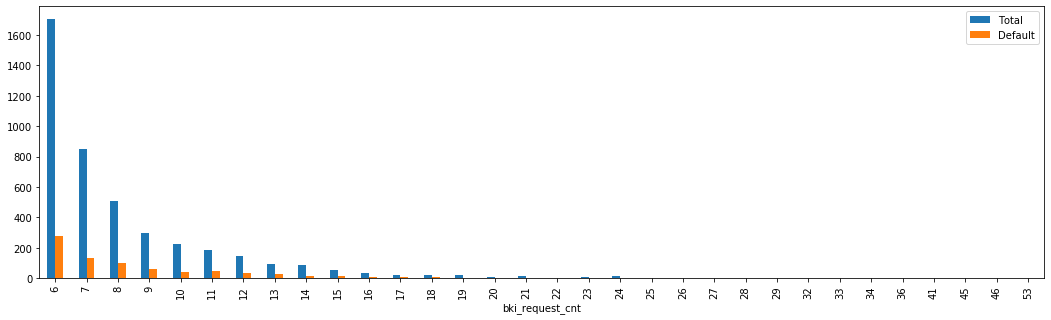

In [87]:
# Вот наши выбросы ( вместе с дефолтами). Видно, что при количестве обращений больше 9
# мы не в состоянии статистически достоверно судить о проценте дефолтов на основе имеющихся данных 
#(число дефолтов в данных слишком мало)
s1 = (data.loc[data.default==1]).groupby(by='bki_request_cnt').agg({'client_id':'count'})
s2 = data.groupby(by='bki_request_cnt').agg({'client_id':'count'})

request = pd.concat([s2,s1], axis=1).fillna(0)
request.columns = ['Total','Default']
request[request.index>=6].plot(kind='bar',figsize=(18,5));

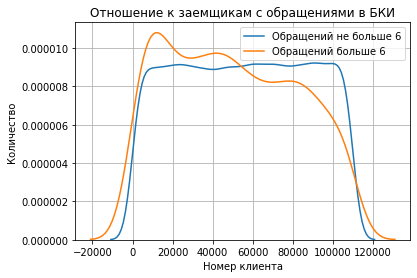

In [88]:
# Проверим, как менялось отношение банка к таким заемщикам в зависимости от номера заемщика:
# (возьмем число обращений, равное 6, чтобы количество данных было достаточно для достоверного графика)
sns.kdeplot(data.loc[data.bki_request_cnt <= 6, 'client_id'] , label = 'Обращений не больше 6')
sns.kdeplot(data.loc[data.bki_request_cnt > 6, 'client_id'] , label = 'Обращений больше 6')
plt.xlabel('Номер клиента'); plt.ylabel('Количество'); plt.title('Отношение к заемщикам с обращениями в БКИ');
plt.grid(axis='both');

Мы видим, что, начиная примерно с клиента номер 50000, банк стал хуже кредитовать заемщиков с числом обращений в БКИ, большим или равным 6. Исследуя дальше, мы обнаруживаем, что примерно в это время изменилось отношение к заемщикам с числом обращений, большим или равным 2. Посмотрите на график ниже:

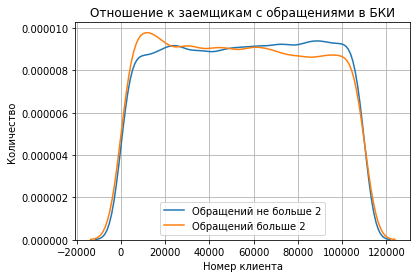

In [89]:
sns.kdeplot(data.loc[data.bki_request_cnt <= 2, 'client_id'] , label = 'Обращений не больше 2')
sns.kdeplot(data.loc[data.bki_request_cnt > 2, 'client_id'] , label = 'Обращений больше 2')
plt.xlabel('Номер клиента'); plt.ylabel('Количество'); plt.title('Отношение к заемщикам с обращениями в БКИ');
plt.grid(axis='both');

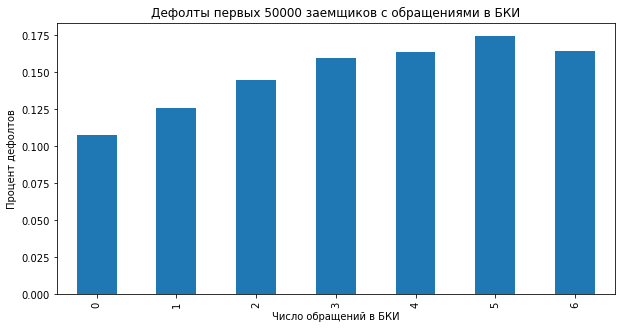

In [90]:
# Вероятно, кредитный отдел что-то выяснил, проанализировав первые 50000 заемщиков:
default_mean = pd.Series(data.loc[(data.bki_request_cnt == i) & (
    data.client_id <= 50000), 'default'].mean() for i in range(7))
default_mean.plot(kind='bar',figsize=(10,5));
plt.xlabel('Число обращений в БКИ'); plt.ylabel('Процент дефолтов'); 
plt.title('Дефолты первых 50000 заемщиков с обращениями в БКИ');

Суммируя зависимости, выявленные выше, предлагаю создать 2 признака: бинарный, указывающий на число обращений в БКИ больше 2, и числовой, зависящий от среднего процента дефолтов заемщиков с разным числом обращений в БКИ

In [91]:
# Делаем бинарный признак 'more_2_bki_requests':
data['more_2_bki_requests'] = (data.bki_request_cnt > 2).astype('uint8')

In [92]:
# В нашем датасете всего таких клиентов 30%
data['more_2_bki_requests'].mean()

0.3034322958305668

In [93]:
# Для числового признака создаем список чисел обращений в БКИ:
bkircnt_lst = data.bki_request_cnt.unique()

In [94]:
# Агрегируем средний процент дефолта
def_by_bkircnt = data.groupby(by='bki_request_cnt').agg({'default':'mean'})

In [95]:
# Вспоминаем общее число выбросов. Полагаю, мы не будем удалять их из датасета, 
# но зададим повышенное значение числового признака.
len(data[data.bki_request_cnt>=8])

1755

In [96]:
# Присваиваем значения признака
data['def_by_bkircnt'] = 0
for bkircnt in bkircnt_lst:    
    mask = (data.bki_request_cnt==bkircnt)
    if bkircnt<8:
        data.loc[mask,'def_by_bkircnt'] = (def_by_bkircnt['default'][bkircnt] - def_mean)/def_mean
    else:
        data.loc[mask,'def_by_bkircnt'] = (0.2 - def_mean)/def_mean

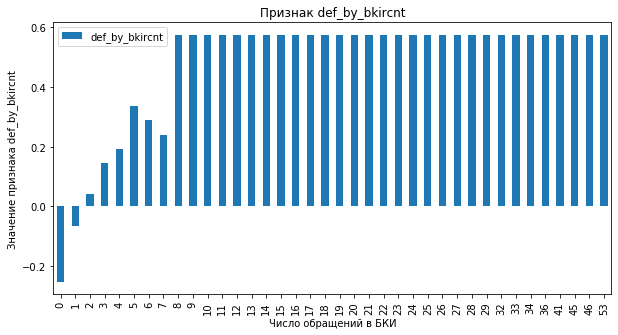

In [97]:
# Смотрим на графике, что получили:
data.groupby(by='bki_request_cnt').agg({'def_by_bkircnt':'mean'}).plot(kind='bar', figsize=(10,5));
plt.xlabel('Число обращений в БКИ'); plt.ylabel('Значение признака def_by_bkircnt'); 
plt.title('Признак def_by_bkircnt');

## Домашний адрес и рабочий адрес

Тип домашнего и рабочего адреса заемщиков высоко скоррелированы.

In [98]:
data[['home_address','work_address']].corr()

,home_address,work_address
home_address,1.000000,0.728139
work_address,0.728139,1.000000


Конечно, эти признаки являются не числовыми, а категориальными, но, возможно, если мы сделаем на основе них "ортогональные" признаки, нам это пойдет на пользу. Поехали.

In [99]:
# Представляем корреляционную матрицу в виде массива Numpy
A = np.array(data[['home_address','work_address']].corr())

In [100]:
A

array([[1.        , 0.72813867],
       [0.72813867, 1.        ]])

In [101]:
# Находим собственные значения и собственные вектора:
B = np.linalg.eig(A)

In [102]:
# Собственные значения корреляционной матрицы:
B[0]

array([1.72813867, 0.27186133])

In [103]:
# И собственные вектора ( столбцы, вспоминаем, что (2**0.5)/2 = 0.70710678):
B[1]

array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]])

То есть, говоря по простому, наши будущие признаки будут равны ('home_address'+'work_address') и (-'home_address'+'work_address'), так как потом значения мы все равно будем нормировать. Должен отметить, нашему банку попалась группа заемщиков с потрясающе подобранными адресами.

In [104]:
data['home_and_work'] = data.home_address + data.work_address
data['work_minus_home'] = - data.home_address + data.work_address

In [105]:
# Признак 'home_and_work' ожидаемо принимает значения от 2 до 6
data.home_and_work.value_counts(normalize=True)

5    0.524546
3    0.266494
2    0.108863
4    0.084364
6    0.015732
Name: home_and_work, dtype: float64

In [106]:
# Признак 'work_minus_home' принимает значения от -2 до 2
data.work_minus_home.value_counts(normalize=True)

 1    0.786311
 0    0.138715
 2    0.069920
-1    0.004729
-2    0.000325
Name: work_minus_home, dtype: float64

In [107]:
# Начнем с группировки по значениям признака 'home_and_work': делаем список значений
home_and_work_lst = data.home_and_work.unique()

In [108]:
def_by_home_and_work = data.groupby(by='home_and_work').agg({'default':'mean'})

In [109]:
def_by_home_and_work

,default
home_and_work,
2,0.075554
3,0.100676
4,0.092194
5,0.156932
6,0.117140


In [110]:
data['def_by_home_and_work'] = 0
for home in home_and_work_lst:
    mask = data.home_and_work==home
    data.loc[mask,'def_by_home_and_work'] = (def_by_home_and_work['default'][home] - def_mean)/def_mean

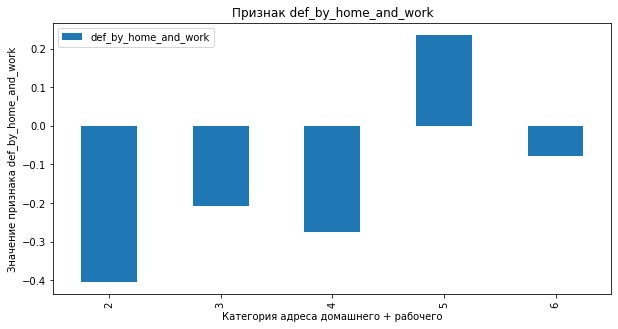

In [111]:
data.groupby(by='home_and_work').agg({'def_by_home_and_work':'mean'}).plot(kind='bar', figsize=(10,5));
plt.xlabel('Категория адреса домашнего + рабочего'); plt.ylabel('Значение признака def_by_home_and_work'); 
plt.title('Признак def_by_home_and_work');

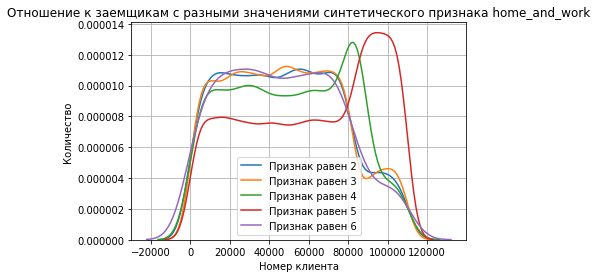

In [112]:
# Выясним, как менялось отношение банка к заемщикам с разными значениями признака с течением времени
sns.kdeplot(data.loc[data.home_and_work == 2, 'client_id'] , label = 'Признак равен 2')
sns.kdeplot(data.loc[data.home_and_work == 3, 'client_id'] , label = 'Признак равен 3')
sns.kdeplot(data.loc[data.home_and_work == 4, 'client_id'] , label = 'Признак равен 4')
sns.kdeplot(data.loc[data.home_and_work == 5, 'client_id'] , label = 'Признак равен 5')
sns.kdeplot(data.loc[data.home_and_work == 6, 'client_id'] , label = 'Признак равен 6')
plt.xlabel('Номер клиента'); plt.ylabel('Количество'); 
plt.title('Отношение к заемщикам с разными значениями синтетического признака home_and_work');
plt.grid(axis='both');

После 70000 клиента отношение банка к заемщикам  с определенными домашними и рабочими адресами изменилось. Похоже, банк нашел сначала один Клондайк ( признак равен 4), а потом - другой ( признак равен 5). Это очень перспективный признак для нашей модели.

In [113]:
# Проделываем аналогичное для второго признака
work_minus_home_lst = data.work_minus_home.unique()

In [114]:
def_by_work_minus_home = data.groupby(by='work_minus_home').agg({'default':'mean'})

In [115]:
# Выясняем, что клиенты со значением признака -2 вовсе не имеют дефолтов:
def_by_work_minus_home

,default
work_minus_home,
-2,0.000000
-1,0.060172
0,0.084595
1,0.138448
2,0.087403


In [116]:
data['def_by_work_minus_home'] = 0
for work in work_minus_home_lst:
    mask = data.work_minus_home==work
    data.loc[mask,'def_by_work_minus_home'] = (def_by_work_minus_home['default'][work] - def_mean)/def_mean

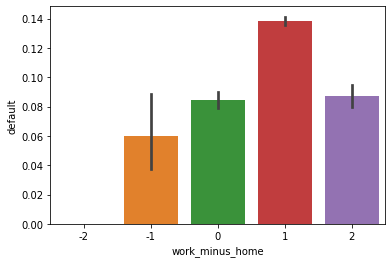

In [117]:
sns.barplot(data=data, x='work_minus_home', y='default');

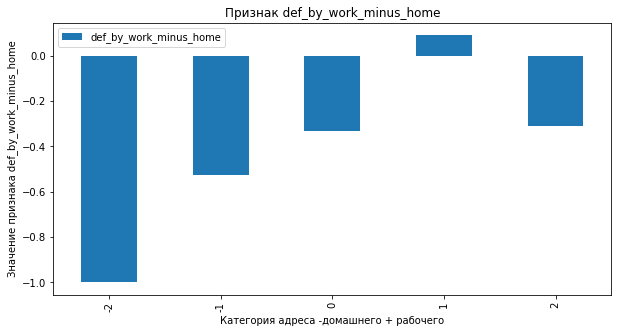

In [118]:
data.groupby(by='work_minus_home').agg({'def_by_work_minus_home':'mean'}).plot(kind='bar', figsize=(10,5));
plt.xlabel('Категория адреса -домашнего + рабочего'); plt.ylabel('Значение признака def_by_work_minus_home'); 
plt.title('Признак def_by_work_minus_home');

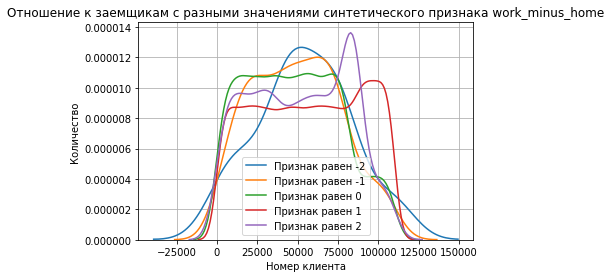

In [119]:
# Выясним, как менялось отношение банка к заемщикам с разными значениями признака с течением времени
sns.kdeplot(data.loc[data.work_minus_home == -2, 'client_id'] , label = 'Признак равен -2')
sns.kdeplot(data.loc[data.work_minus_home == -1, 'client_id'] , label = 'Признак равен -1')
sns.kdeplot(data.loc[data.work_minus_home == 0, 'client_id'] , label = 'Признак равен 0')
sns.kdeplot(data.loc[data.work_minus_home == 1, 'client_id'] , label = 'Признак равен 1')
sns.kdeplot(data.loc[data.work_minus_home == 2, 'client_id'] , label = 'Признак равен 2')
plt.xlabel('Номер клиента'); plt.ylabel('Количество'); 
plt.title('Отношение к заемщикам с разными значениями синтетического признака work_minus_home');
plt.grid(axis='both');

Мы видим, что отношение банка к заемщикам с разными значениями признака work_minus_home изменилось, начиная примерно с заемщика номер 70000 - 75000.

In [120]:
# Банк потерял золотых заемщиков со значением признака -2. Непонятно, почему. Посчитаем, сколько их было всего:
# (видим, что потеря невелика)
len(data[data.work_minus_home == -2])

24

## Доход заемщика

In [121]:
data.income.describe()

count      73799.000000
mean       41099.775417
std        46166.322400
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        48000.000000
max      1000000.000000
Name: income, dtype: float64

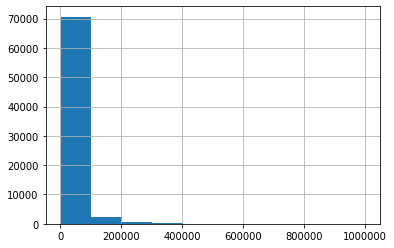

In [122]:
# Признак меняется в диапазоне от 0 до 1000000 рублей, но в основном меньше 100000 рублей
data.income.hist();

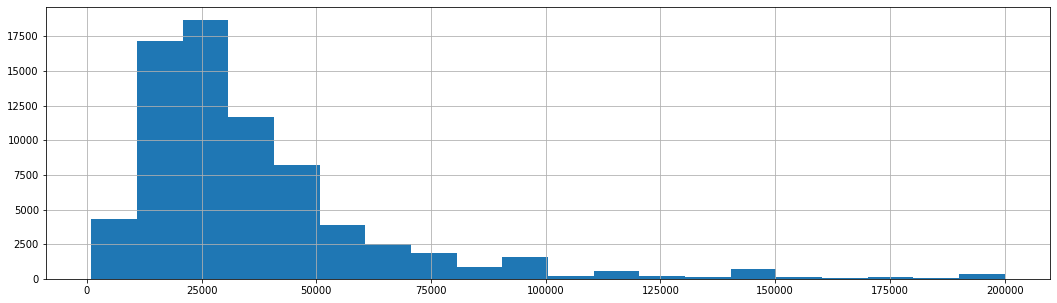

In [123]:
# Присмотримся внимательнее:
data[data.income<=200000].income.hist(bins=20, figsize=(18,5));

Видим, что мода распределения около 25000 рублей в месяц, оно несимметрично, имеет толстыйправый хвост. Если мы отберем этот признак для модели, придется его логарифмировать.

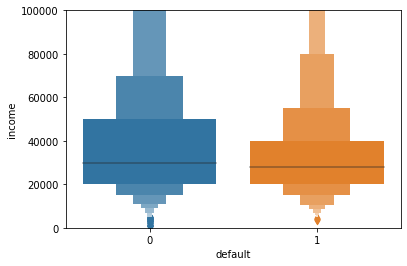

In [124]:
# Дефолтные заемщики, как правило, имеют более низкий доход:
sns.boxenplot(x='default', y='income', data=data); plt.ylim(0, 100000);

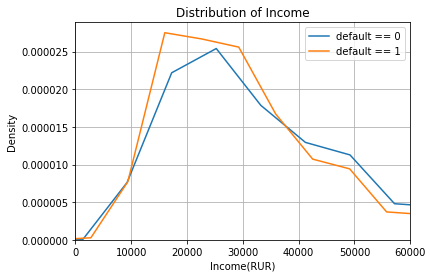

In [125]:
# Обнаруживаем, что вероятность дефолта больше, если доход заемщика находится в пределах от 9500 до 37500 руб.
# Возможно, мы используем этот факт для создания категорий по доходу.
sns.kdeplot(data.loc[data.default == 0, 'income'] , label = 'default == 0',)
sns.kdeplot(data.loc[data.default == 1, 'income'] , label = 'default == 1')
plt.xlabel('Income(RUR)'); plt.ylabel('Density'); plt.title('Distribution of Income');plt.xlim(0, 60000);
plt.grid(b=True,axis='both')

In [126]:
perc = data.income.describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]).values[4:13]

In [127]:
perc

array([14000., 18000., 22000., 25000., 30000., 35000., 40000., 50000.,
       70000.])

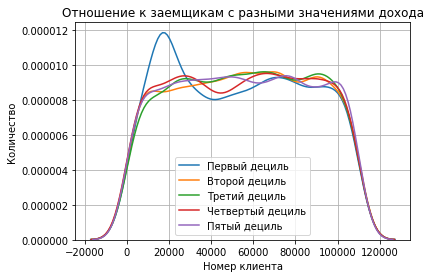

In [128]:
# Выясним, как менялось отношение банка к заемщикам с разными значениями дохода с течением времени
sns.kdeplot(data.loc[data.income <= 14000., 'client_id'] , label = 'Первый дециль')
sns.kdeplot(data.loc[(data.income > 14000.)&(data.income <= 18000.), 'client_id'] , label = 'Второй дециль')
sns.kdeplot(data.loc[(data.income > 18000.)&(data.income <= 22000.), 'client_id'] , label = 'Третий дециль')
sns.kdeplot(data.loc[(data.income > 22000.)&(data.income <= 25000.), 'client_id'] , label = 'Четвертый дециль')
sns.kdeplot(data.loc[(data.income > 25000.)&(data.income <= 30000.), 'client_id'] , label = 'Пятый дециль')
plt.xlabel('Номер клиента'); plt.ylabel('Количество'); 
plt.title('Отношение к заемщикам с разными значениями дохода');
plt.grid(axis='both');

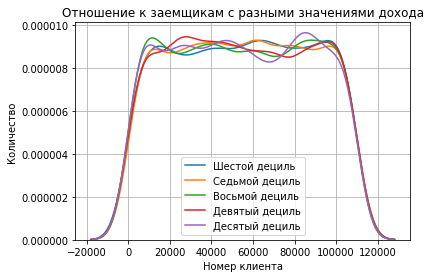

In [129]:
sns.kdeplot(data.loc[(data.income > 30000.)&(data.income <= 35000.), 'client_id'] , label = 'Шестой дециль')
sns.kdeplot(data.loc[(data.income > 35000.)&(data.income <= 40000.), 'client_id'] , label = 'Седьмой дециль')
sns.kdeplot(data.loc[(data.income > 40000.)&(data.income <= 50000.), 'client_id'] , label = 'Восьмой дециль')
sns.kdeplot(data.loc[(data.income > 50000.)&(data.income <= 70000.), 'client_id'] , label = 'Девятый дециль')
sns.kdeplot(data.loc[(data.income > 70000.), 'client_id'] , label = 'Десятый дециль')
plt.xlabel('Номер клиента'); plt.ylabel('Количество'); 
plt.title('Отношение к заемщикам с разными значениями дохода');
plt.grid(axis='both');

Мы видим, что среди первых 30000 клиентов было относительно больше малообеспеченных, потом ситуация выровнялась.

In [130]:
# Построим категориальный признак, основанный на относительной вероятности дефолта для 2 групп заемщиков:
# с доходом <=37500 а также с доходом >37500 (так как с доходом меньше 9500 у нас всего 2660 клиентов)
data['def_by_income'] = 0

In [131]:
mask = (data.income<=37500)
data.loc[mask,'def_by_income'] = (data.loc[mask,'default'].mean() - def_mean)/def_mean

In [132]:
mask = (data.income>37500)
data.loc[mask,'def_by_income'] = (data.loc[mask,'default'].mean() - def_mean)/def_mean

In [133]:
# Доход меньше 37500 имеет 63% наших клиентов
data.def_by_income.value_counts(normalize=True)

 0.117234    0.628992
-0.198754    0.371008
Name: def_by_income, dtype: float64

Важность этого признака для модели мы выясним потом, а сейчас просто посмотрим, как его оценивал банк: стал ли он с течением времени хуже относиться к заемщикам с низким доходом, или нет:

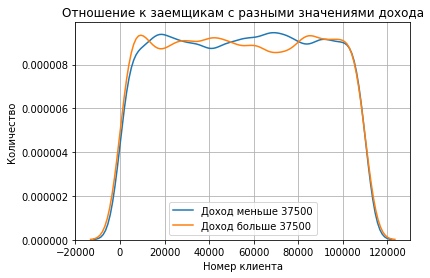

In [134]:
# Видим, что этот признак банк игнорирует
sns.kdeplot(data.loc[(data.income <= 37500.), 'client_id'] , label = 'Доход меньше 37500')
sns.kdeplot(data.loc[(data.income > 37500.), 'client_id'] , label = 'Доход больше 37500')
plt.xlabel('Номер клиента'); plt.ylabel('Количество'); 
plt.title('Отношение к заемщикам с разными значениями дохода');
plt.grid(axis='both');

## Наличие заграничного паспорта у заемщика

In [135]:
# Загранпаспорт есть у 15% заемщиков
data.foreign_passport.value_counts(normalize=True)

N    0.850052
Y    0.149948
Name: foreign_passport, dtype: float64

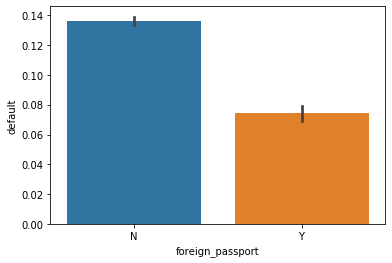

In [136]:
# Но они гораздо аккуратнее возвращяют долги
sns.barplot(data=data, x='foreign_passport', y='default');

In [137]:
# Поэтому создадим признак, отражающий корреляцию дефолтов с наличием паспорта
passport_lst = data.foreign_passport.unique()

In [138]:
def_by_passport = data.groupby(by='foreign_passport').agg({'default':'mean'})

In [139]:
def_by_passport

,default
foreign_passport,
N,0.136324
Y,0.074101


In [140]:
data['def_by_passport'] = 0
for passport in passport_lst:
    mask = data.foreign_passport==passport
    data.loc[mask,'def_by_passport'] = (def_by_passport['default'][passport] - def_mean)/def_mean

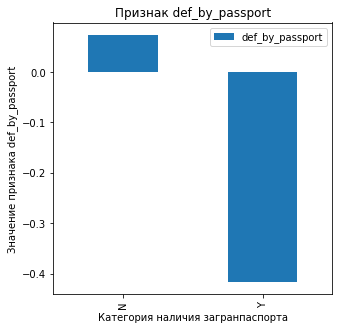

In [141]:
# Изобразим значения признака
data.groupby(by='foreign_passport').agg({'def_by_passport':'mean'}).plot(kind='bar', figsize=(5,5));
plt.xlabel('Категория наличия загранпаспорта'); plt.ylabel('Значение признака def_by_passport'); 
plt.title('Признак def_by_passport');

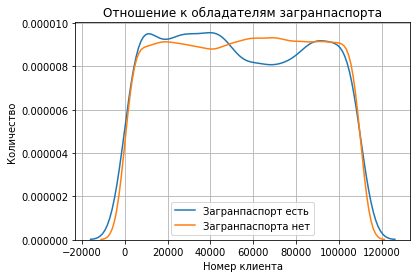

In [142]:
# Выясним, как банк менял отношение к обладателям загранпаспорта
# Видим, что этот признак банк игнорирует
sns.kdeplot(data.loc[(data.foreign_passport == 'Y'), 'client_id'] , label = 'Загранпаспорт есть')
sns.kdeplot(data.loc[(data.foreign_passport == 'N'), 'client_id'] , label = 'Загранпаспорта нет')
plt.xlabel('Номер клиента'); plt.ylabel('Количество'); 
plt.title('Отношение к обладателям загранпаспорта');
plt.grid(axis='both');

Мы видим изменение отношения по признаку загранпаспорта, которое началось с номера 40000, и ситуация вернулась назад к номеру 80000.

In [143]:
# Перекодируем изначальное поле в цифру
data.foreign_passport = data.foreign_passport.map({'Y':1, 'N':0})

## Категориальный признак на основе идентификатора заемщика.

Несколько раз мы замечали, что отношение банка к заемщикам с течением времени ( судя по порядковому номеру заемщика ) менялось, иногда довольно сильно. То есть для того, чтобы наша модель лучше предсказывала дефолт, имеет смысл разбить заемщиков на категории по идентификатору.
Мы помним, что:

 - Примерно с 80000 клиента банк начал кредитовать относительно больше лиц с незаконченным высшим, высшим образованием и слушателей/выпускников аспирантуры, сократив кредитование лиц со средним образованием и с ученой степенью.
 - После 60000 клиента банк немного больше полюбил заемщиков-женщин.
 - Отказников стали хуже кредитовать, начиная примерно с 75000-го клиента. Тех, кто имеет 3 и более отказов - значительно хуже.
 - Начиная примерно с клиента номер 50000, банк стал хуже кредитовать заемщиков с числом обращений в БКИ, большим или равным 6. Исследуя дальше, мы обнаруживаем, что примерно в это время изменилось отношение к заемщикам с числом обращений, большим или равным 2.
 - После 70000 клиента отношение банка к заемщикам с определенными домашними и рабочими адресами изменилось.
 - Мы видим, что отношение банка к заемщикам с разными значениями признака work_minus_home изменилось, начиная примерно с заемщика номер 70000 - 75000.
 - Мы видим изменение отношения по признаку загранпаспорта, которое началось с номера 40000, и ситуация вернулась назад к номеру 80000.
 - Среди первых 30000 клиентов было относительно больше малообеспеченных, потом ситуация выровнялась.


Конечно, значения идентификатора заемщика из предыдущего абзаца, начиная с которых в политике банка происходили изменения, очень приблизительны. Я считаю хлрошим выходом разбить заемщиков на 11 групп по идентификатору, в каждой группе он будет изменяться в пределах 10000, то есть первая группа: 0<client_id<=10000, вторая группа: 10000<client_id<=20000 и так далее. Это легко реализовать:

In [144]:
data['client_group'] = np.ceil(data.client_id/10000)

In [146]:
# Перемещаем 98 записей из 12 группы в 11
data.loc[data.client_group==12,'client_group'] = 11

In [147]:
data.client_group.value_counts()

11.0    6850
3.0     6741
10.0    6739
7.0     6736
9.0     6729
1.0     6721
2.0     6700
6.0     6685
8.0     6663
5.0     6633
4.0     6602
Name: client_group, dtype: int64

# Отбор признаков для модели

In [148]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   client_id               73799 non-null  int64  
 1   education               73799 non-null  int64  
 2   sex                     73799 non-null  int64  
 3   age                     73799 non-null  int64  
 4   car                     73799 non-null  int64  
 5   car_type                73799 non-null  int64  
 6   decline_app_cnt         73799 non-null  int64  
 7   good_work               73799 non-null  int64  
 8   bki_request_cnt         73799 non-null  int64  
 9   home_address            73799 non-null  int64  
 10  work_address            73799 non-null  int64  
 11  income                  73799 non-null  int64  
 12  foreign_passport        73799 non-null  int64  
 13  default                 73799 non-null  int64  
 14  def_by_edu              73799 non-null

In [149]:
data.columns

Index(['client_id', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'bki_request_cnt', 'home_address',
       'work_address', 'income', 'foreign_passport', 'default', 'def_by_edu',
       'def_by_sex', 'def_by_age', 'def_by_any_car', 'has_decline',
       'def_by_decappcnt', 'def_by_goodw', 'more_2_bki_requests',
       'def_by_bkircnt', 'home_and_work', 'work_minus_home',
       'def_by_home_and_work', 'def_by_work_minus_home', 'def_by_income',
       'def_by_passport', 'client_group'],
      dtype='object')

In [151]:
new_cols = ['def_by_edu',
       'def_by_sex', 'def_by_age', 'def_by_any_car', 'has_decline',
       'def_by_decappcnt', 'def_by_goodw', 'more_2_bki_requests',
       'def_by_bkircnt', 'home_and_work', 'work_minus_home',
       'def_by_home_and_work', 'def_by_work_minus_home', 'def_by_income',
       'def_by_passport', 'client_group']

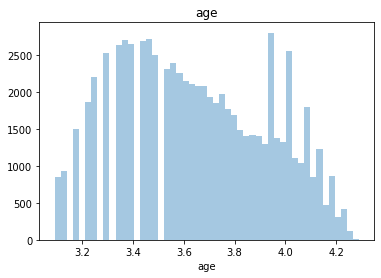

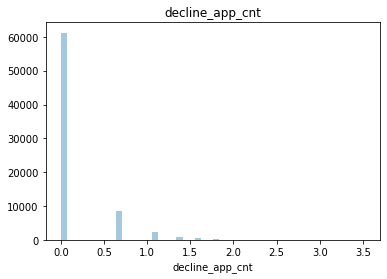

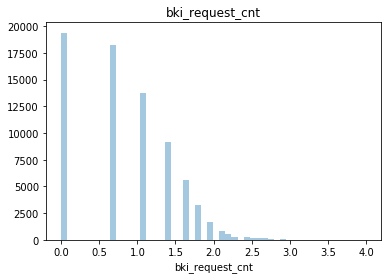

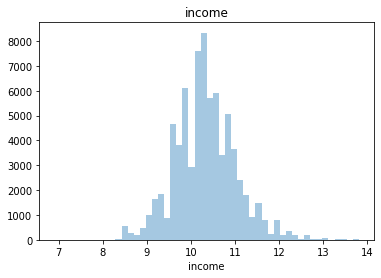

In [152]:
# бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# категориальные переменные
cat_cols = ['education', 'work_address', 'home_address']

# числовые переменные
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']

for i in num_cols:
    plt.figure()
    sns.distplot((np.log(data[i] + 1)), kde = False, rug=False)
    plt.title(i)
    plt.show()

In [39]:
# for i in num_cols:
#     data[i] = np.log(data[i]+1)

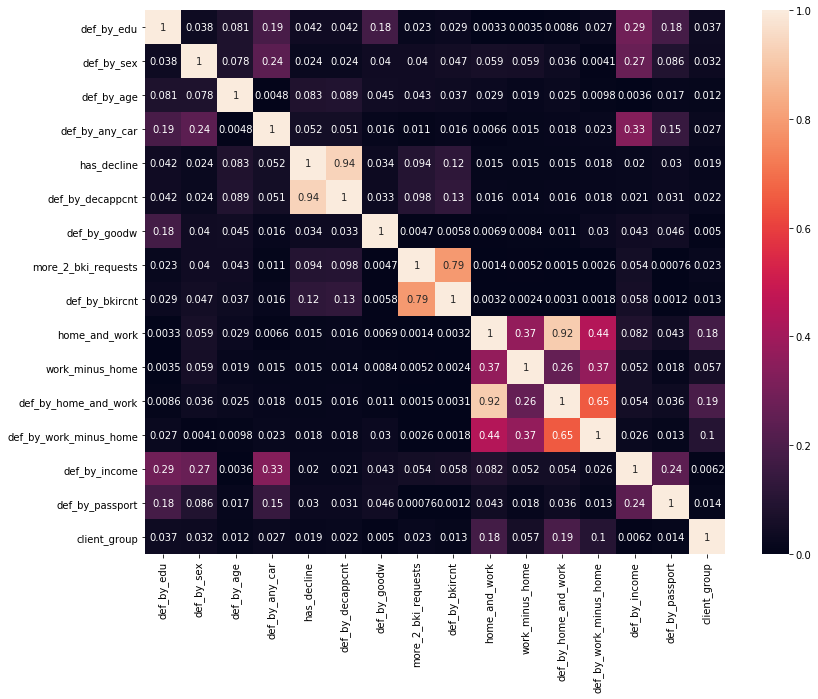

In [157]:
plt.figure(figsize=(13, 10))
sns.heatmap(data[new_cols].corr().abs(), annot=True, vmin=0, vmax=1);

In [101]:
# корреляция числовых признаков между собой невелика
data[num_cols + new_cols].corr().abs()

,age,decline_app_cnt,bki_request_cnt,income,def_by_edu,def_by_sex,def_by_age,def_by_any_car,def_by_decappcnt,def_by_goodw,def_by_bkircnt,def_by_home,def_by_workaddr,def_by_income,def_by_passport
age,1.000000,0.111175,0.046265,0.018900,0.108941,0.136296,0.665119,0.050601,0.120691,0.076158,0.040648,0.009850,0.004347,0.059887,0.042663
decline_app_cnt,0.111175,1.000000,0.155894,0.021687,0.034528,0.020880,0.084656,0.043110,0.926749,0.027359,0.145023,0.012996,0.015328,0.016867,0.026306
bki_request_cnt,0.046265,0.155894,1.000000,0.082983,0.040512,0.044374,0.039603,0.000931,0.160736,0.005738,0.946465,0.009349,0.006637,0.074440,0.007824
income,0.018900,0.021687,0.082983,1.000000,0.243528,0.192098,0.024199,0.305607,0.026923,0.022705,0.072845,0.040610,0.053855,0.526518,0.229686
def_by_edu,0.108941,0.034528,0.040512,0.243528,1.000000,0.038159,0.083035,0.187683,0.041067,0.178396,0.032913,0.002178,0.000708,0.286772,0.180656
def_by_sex,0.136296,0.020880,0.044374,0.192098,0.038159,1.000000,0.080992,0.237519,0.023972,0.040247,0.042553,0.034563,0.067229,0.265750,0.086326
def_by_age,0.665119,0.084656,0.039603,0.024199,0.083035,0.080992,1.000000,0.008363,0.090061,0.047489,0.033464,0.023697,0.029711,0.001188,0.018446
def_by_any_car,0.050601,0.043110,0.000931,0.305607,0.187683,0.237519,0.008363,1.000000,0.050473,0.016424,0.006112,0.015480,0.000873,0.333798,0.146008
def_by_decappcnt,0.120691,0.926749,0.160736,0.026923,0.041067,0.023972,0.090061,0.050473,1.000000,0.032649,0.147615,0.012304,0.016641,0.020005,0.030671
def_by_goodw,0.076158,0.027359,0.005738,0.022705,0.178396,0.040247,0.047489,0.016424,0.032649,1.000000,0.006427,0.005386,0.003964,0.042923,0.046361


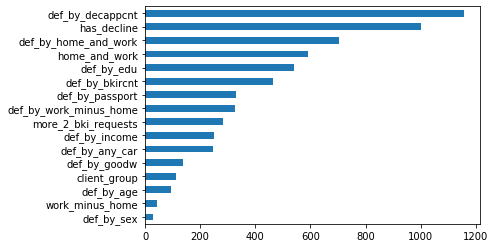

In [158]:
# выясняем относительную важность числовых признаков для модели
imp_num = pd.Series(f_classif(data[new_cols], data['default'])[0], index = new_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [103]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
# убедимся в преобразовании    
data.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,...,def_by_sex,def_by_age,def_by_any_car,def_by_decappcnt,def_by_goodw,def_by_bkircnt,def_by_home,def_by_workaddr,def_by_income,def_by_passport
0,25905,SCH,1,62,1,1,0,0,1,1,...,0.058406,-0.029369,-0.311382,-0.137486,0.050518,-0.064601,-0.268502,-0.192821,0.117307,0.073470
1,63161,SCH,0,59,0,0,0,0,3,2,...,-0.045302,-0.003993,0.078481,-0.137486,0.050518,0.146834,0.221681,0.165075,0.117307,0.073470
2,25887,SCH,1,25,1,0,2,0,1,1,...,0.058406,0.126449,0.045283,0.917554,0.050518,-0.064601,-0.268502,-0.192821,0.117307,-0.416499
3,16222,SCH,0,53,0,0,0,0,2,2,...,-0.045302,-0.150799,0.078481,-0.137486,0.050518,0.042362,0.221681,0.165075,0.117307,0.073470
4,101655,GRD,1,48,0,0,0,1,1,2,...,0.058406,-0.052154,0.078481,-0.137486,-0.255849,-0.064601,0.221681,0.165075,0.117307,-0.416499


In [104]:
data.education.unique()

array(['SCH', 'GRD', 'UGR', 'PGR', 'ACD'], dtype=object)

In [105]:
data.education.value_counts(dropna=False)

SCH    39167
GRD    23365
UGR     9816
PGR     1257
ACD      194
Name: education, dtype: int64

In [106]:
# нам понадобятся числа для кодирования уровня образования - делаем словарь
edu_dict = {'SCH':1, 'GRD':3, 'UGR':2, 'PGR':4, 'ACD':5}

In [107]:
# Заменяем коды уровня образования числовыми значениями согласно нашему словарю
data.education.replace(edu_dict, inplace=True)

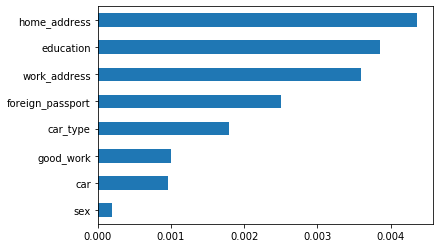

In [108]:
# исследуем важность категориальных признаков
imp_cat = pd.Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

In [109]:
# перекодируем категориальные признаки
X_cat = OneHotEncoder(sparse = False).fit_transform(data[cat_cols].values)

In [110]:
X_cat.shape

(73799, 11)

In [111]:
X_cat[:5]

array([[1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0.]])

In [159]:
data[new_cols + ['income']].head()

,def_by_edu,def_by_sex,def_by_age,def_by_any_car,has_decline,def_by_decappcnt,def_by_goodw,more_2_bki_requests,def_by_bkircnt,home_and_work,work_minus_home,def_by_home_and_work,def_by_work_minus_home,def_by_income,def_by_passport,client_group,income
0,0.183564,0.058406,-0.029369,-0.311382,0,-0.137486,0.050518,0,-0.064601,3,1,-0.207234,0.090197,0.117234,0.073470,3.0,18000
1,0.183564,-0.045302,-0.003993,0.078481,0,-0.137486,0.050518,1,0.146834,5,1,0.235748,0.090197,0.117234,0.073470,7.0,19000
2,0.183564,0.058406,0.126449,0.045283,1,0.917554,0.050518,0,-0.064601,3,1,-0.207234,0.090197,0.117234,-0.416499,3.0,30000
3,0.183564,-0.045302,-0.150799,0.078481,0,-0.137486,0.050518,0,0.042362,5,1,0.235748,0.090197,0.117234,0.073470,2.0,10000
4,-0.290578,0.058406,-0.052154,0.078481,0,-0.137486,-0.255849,0,-0.064601,5,1,0.235748,0.090197,0.117234,-0.416499,11.0,30000


In [160]:
# Стандартизация числовых переменных
X_num = StandardScaler().fit_transform(data[new_cols + ['income']].values)

In [161]:
X_num[:5]

array([[ 0.81997197,  1.13545757, -0.30863331, -2.06038389, -0.45342058,
        -0.42398319,  0.44435632, -0.66000805, -0.30964377, -0.94576184,
         0.16732646, -0.81353365,  0.51826367,  0.76801346,  0.41999808,
        -0.9503824 , -0.50036327],
       [ 0.81997197, -0.88070222, -0.05004249,  0.51930104, -0.45342058,
        -0.42398319,  0.44435632,  1.51513303,  0.76222337,  0.8190656 ,
         0.16732646,  0.92547439,  0.51826367,  0.76801346,  0.41999808,
         0.31115304, -0.47870231],
       [ 0.81997197,  1.13545757,  1.27920526,  0.29963332,  2.20545789,
         2.84862904,  0.44435632, -0.66000805, -0.30964377, -0.94576184,
         0.16732646, -0.81353365,  0.51826367,  0.76801346, -2.38096327,
        -0.9503824 , -0.24043177],
       [ 0.81997197, -0.88070222, -1.54604032,  0.51930104, -0.45342058,
        -0.42398319,  0.44435632, -0.66000805,  0.23260259,  0.8190656 ,
         0.16732646,  0.92547439,  0.51826367,  0.76801346,  0.41999808,
        -1.26576626

In [199]:
# Объединяем
# X = np.hstack([X_num, data[bin_cols].values, X_cat])
X = np.hstack([X_num,data.loc[:,['default']]])
# Y = data['default'].values

In [162]:
Y = data['default'].values

In [200]:
X.shape

(73799, 13)

In [201]:
X[:5]

array([[ 0.81997197,  1.13545757, -0.29796617, -2.06038389, -0.41722065,
         0.44435632, -0.28360865, -1.10950514, -0.89435711,  0.76848993,
         0.41999808, -0.50036327,  0.        ],
       [ 0.81997197, -0.88070222, -0.0405126 ,  0.51930104, -0.41722065,
         0.44435632,  0.61566074,  0.91602987,  0.76566314,  0.76848993,
         0.41999808, -0.47870231,  0.        ],
       [ 0.81997197,  1.13545757,  1.28288929,  0.29963332,  2.77330595,
         0.44435632, -0.28360865, -1.10950514, -0.89435711,  0.76848993,
        -2.38096327, -0.24043177,  0.        ],
       [ 0.81997197, -0.88070222, -1.52993122,  0.51930104, -0.41722065,
         0.44435632,  0.17132232,  0.91602987,  0.76566314,  0.76848993,
         0.41999808, -0.67365093,  0.        ],
       [-1.2979962 ,  1.13545757, -0.52912959,  0.51930104, -0.41722065,
        -2.25044622, -0.28360865,  0.91602987,  0.76566314,  0.76848993,
        -2.38096327, -0.24043177,  0.        ]])

In [214]:
X[:5,-1]

array([0., 0., 0., 0., 0.])

In [203]:
Y.shape

(73799,)

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X_num, Y, test_size=0.2, random_state=42)

In [205]:
default = X_train[X_train[:,-1] == 1]
no_default = X_train[X_train[:,-1] == 0]

In [206]:
default.shape

(7545, 13)

In [207]:
no_default.shape

(51494, 13)

In [208]:
new_default = np.repeat(default, 7, axis=0)

In [209]:
new_default.shape

(52815, 13)

In [210]:
new_X_train = np.vstack((new_default, no_default))

In [211]:
new_X_train.shape

(104309, 13)

In [212]:
np.random.shuffle(new_X_train)

In [215]:
new_Y_train = new_X_train[:,-1]

In [216]:
new_Y_train[:5]

array([1., 0., 1., 0., 0.])

In [217]:
new_X_train = new_X_train[:,:-1]

In [218]:
new_X_train[:5]

array([[ 0.15921326, -0.88070222,  0.43254973,  0.51930104,  1.44664657,
         0.44435632,  0.17132232,  0.91602987,  0.76566314, -1.30205898,
        -2.38096327,  0.19278739],
       [ 0.81997197,  1.13545757,  0.26083303,  0.51930104,  3.48806494,
         0.44435632, -0.28360865, -1.10950514,  0.76566314, -1.30205898,
        -2.38096327,  1.2758353 ],
       [ 0.81997197, -0.88070222, -0.208951  ,  0.51930104,  1.44664657,
         0.44435632,  0.17132232, -1.10950514, -0.89435711,  0.76848993,
         0.41999808, -0.28375369],
       [ 0.81997197,  1.13545757, -1.89834746,  0.51930104, -0.41722065,
         0.44435632,  0.61566074,  0.91602987, -0.89435711, -1.30205898,
         0.41999808,  0.12780452],
       [-1.2979962 ,  1.13545757,  0.32258328,  0.51930104,  1.44664657,
         0.44435632,  0.17132232,  0.91602987,  0.76566314, -1.30205898,
         0.41999808,  0.62600655]])

In [219]:
new_X_train.shape

(104309, 12)

In [163]:
model = LogisticRegression()

In [174]:
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20), 'class_weight':['balanced',{0:1,1:8},{0:1,1:5},{0:1,1:10}],
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [250, 500, 1000,2500, 5000]
    }
]

In [175]:
clf = GridSearchCV(model, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)

In [176]:
best_clf = clf.fit(X_num,Y)

Fitting 3 folds for each of 8000 candidates, totalling 24000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed: 22.9min
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed: 27.0min
[Parallel(n_jobs=-1)]: Done 11242 tasks      |

In [179]:
best_clf.best_estimator_

LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=250, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [178]:
best_clf.score(X_num,Y)

0.8730064093009391

In [180]:
clf = LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=250, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [184]:
clf.fit(X_train,y_train)

LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=250, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [185]:
y_pred = clf.predict(X_test)

In [186]:
clf.score(X_test, y_test)

0.876219512195122

In [187]:
cnf = confusion_matrix(y_test, y_pred)

Text(0.5, 257.44, 'Предсказание дефолта')

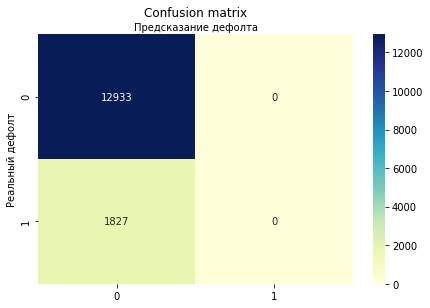

In [188]:
class_names=['нет','да'] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.2)
plt.ylabel('Реальный дефолт')
plt.xlabel('Предсказание дефолта')

In [189]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

Accuracy: 0.876219512195122
Precision: 0.0
Recall: 0.0


C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


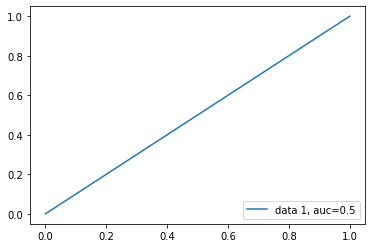

In [190]:
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()